Primeramente, en caso de no haberlo hecho antes, buildeamos el proyecto de c++ como modulos de python

In [ ]:
!sh build.sh

A continuación importamos las librerias necesarias y obtenemos la información del dataset de MNIST, dividido de tal forma que 4/5 del total se usan como entrenamiento y el 1/5 restante como validación

In [2]:
import metnum
import pandas as pd 
import numpy as np
from utils import get_MNIST
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.datasets import fetch_openml

In [4]:
X_train, y_train, X_val, y_val = get_MNIST(0.8)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 56000 instancias de entrenamiento y 14000 de validación


In [5]:
k = 3
alpha = 19

Separamos el dataframe en instancias de train y test y entrenamos con kNN+PCA

In [6]:
pca = metnum.PCA(alpha)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_val_PCA = pca.transform(X_val)
        
clf_metnum = metnum.KNNClassifier(k)
clf_metnum.fit(X_train_PCA, y_train)
resultados = clf_metnum.predict(X_val_PCA)

Graficamos la cantidad de predicciones correctas y erroneas para cada clase con una matriz de confusión para mostrar en los casos erroneos, que clase asigno en lugar de la correcta

In [7]:
%matplotlib inline
cMatrix = confusion_matrix(y_val,resultados)

Text(33.0, 0.5, 'Predicted')

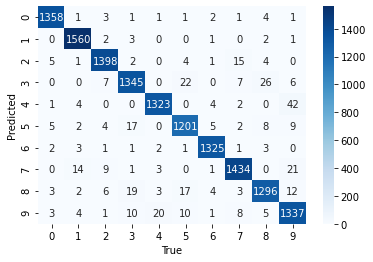

In [8]:
ax = plt.axes()
hm = heatmap(cMatrix, ax= ax, cmap="Blues", annot=True, fmt = "d")

ax.set_xlabel("True")

ax.set_ylabel("Predicted")

Calculamos los valores de precision y recall para cada clase. La precision la calculamos con la cantidad de imagenes asigandas a cierta clase de manera correcta (true positive) sobre las correctamente asignadas y las que en realidad pertenecian a otra (true positive y false positive). Luego, recall se calcula tambien con la cantidad de imagenes correctamente asigandas a cierta clase sobre las imagenes bien asignadas mas las que pertenecian a dicha clase pero fueron incorrectamente asignadas a otra (true positive y false negative)

In [9]:
precisiones = []
recalls = []
for k in range(10):
    precisiones.append(cMatrix[k][k]/(cMatrix[k].sum()))
    recalls.append(cMatrix[k][k]/(cMatrix[:,k].sum()))

Mostramos los valores de precision y recall para cada clase 

In [10]:
recalls = pd.Series(recalls)
precisiones = pd.Series(precisiones)
precision_promedio = precisiones.mean()
recall_promedio = recalls.mean()

In [11]:
result = pd.DataFrame([precisiones,recalls]).T
result.columns = ["precision", "recall"]
index = result.index
index.name = "clase"
index = [str(i) for i in range(10)]
index.append("promedio")
result

,precision,recall
clase,,
0,0.989075,0.986202
1,0.994264,0.980515
2,0.977622,0.976939
3,0.951875,0.961401
4,0.961483,0.978550
5,0.958500,0.956210
6,0.989544,0.985863
7,0.966959,0.973523
8,0.949451,0.961424


Tambien calculamos los promedio de ambas métricas y los agregamos al final de la tabla

In [12]:
promedios = pd.Series([result["precision"].mean(),result["recall"].mean()])
promedios.index = ["precision","recall"]
promedios.name = "promedio"
result = result.append(promedios)

In [13]:
result

,precision,recall
clase,,
0,0.989075,0.986202
1,0.994264,0.980515
2,0.977622,0.976939
3,0.951875,0.961401
4,0.961483,0.978550
5,0.958500,0.956210
6,0.989544,0.985863
7,0.966959,0.973523
8,0.949451,0.961424


A continuacion vamos a entrenar al modelo con un clasificador distinto llamado "Random Forest Classifier" en lugar de kNN y lo compararemos con el segundo

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
rfc_preds = model_rfc.predict(X_val)
print(accuracy_score(y_val, rfc_preds))

0.9717142857142858


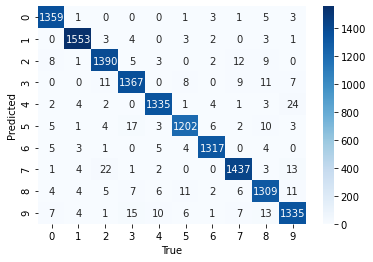

In [15]:
cMatrix_forest = confusion_matrix(y_val,rfc_preds)
heatmap(cMatrix_forest,ax= ax, cmap="Blues", annot=True, fmt = "d")
ax = plt.axes()
hm = heatmap(cMatrix_forest, ax= ax, cmap="Blues", annot=True, fmt = "d")

ax.set_xlabel("True")

ax.set_ylabel("Predicted")

def func(x, pos):
    for k in range(15):
        return "{:.2f}".format(x).replace(str(k), "")

#annotate_heatmap(hm, valfmt=matplotlib.ticker.FuncFormatter(func))


Mostramos los resultados de accuracy calculados con ambos clasificadores

In [16]:
print("kNN: ", accuracy_score(y_val, resultados), "\nRFC: ", accuracy_score(y_val, rfc_preds))

kNN:  0.9697857142857143 
RFC:  0.9717142857142858


Por último, calculamos y mostramos la métrica Kappa de Cohen del modelo entrenado con nuestra versión de kNN

In [17]:
from sklearn.metrics import cohen_kappa_score

In [18]:
cohen_kappa_score(rfc_preds,resultados)

0.9645095962609289

In [19]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)

5

In [20]:
confusions = []
accuracies_knn = []
accuracies_rfc = []
for train_index, test_index in kf.split(X):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     model_rfc_kfold = RandomForestClassifier()
     model_knn_kfold = metnum.KNNClassifier(3)

     pca_kfold = metnum.PCA(19)
     pca_kfold.fit(X_train)
     X_train_pca_kfold = pca_kfold.transform(X_train)
     X_test_pca_kfold = pca_kfold.transform(X_test)

     model_knn_kfold.fit(X_train_pca_kfold, y_train)
     model_rfc_kfold.fit(X_train_pca_kfold, y_train)

     preds_knn = model_knn_kfold.predict(X_test_pca_kfold)
     preds_rfc = model_rfc_kfold.predict(X_test_pca_kfold)
     accuracies_knn.append(accuracy_score(y_test,preds_knn))
     accuracies_rfc.append(accuracy_score(y_test,preds_rfc))
     confusions.append(confusion_matrix(y_test, preds_knn))
     confusions.append(confusion_matrix(y_test, preds_rfc))


TRAIN: [14000 14001 14002 ... 69997 69998 69999] TEST: [    0     1     2 ... 13997 13998 13999]
TRAIN: [    0     1     2 ... 69997 69998 69999] TEST: [14000 14001 14002 ... 27997 27998 27999]
TRAIN: [    0     1     2 ... 69997 69998 69999] TEST: [28000 28001 28002 ... 41997 41998 41999]
TRAIN: [    0     1     2 ... 69997 69998 69999] TEST: [42000 42001 42002 ... 55997 55998 55999]
TRAIN: [    0     1     2 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 69997 69998 69999]


In [21]:
confusions_rfc = []
confusions_knn = []
for k in range(10):
    if(k % 2 == 0):
        confusions_knn.append(confusions[k])
    else:
        confusions_rfc.append(confusions[k])


In [29]:
confusion_rfc_prom = np.zeros((10,10))
confusion_knn_prom = np.zeros((10,10))
for k in range(5):
    confusion_rfc_prom = confusion_rfc_prom + confusions_rfc[k]
    confusion_knn_prom = confusion_knn_prom + confusions_knn[k]
confusion_rfc_prom = (confusion_rfc_prom/5).astype("int")
confusion_knn_prom = (confusion_knn_prom/5).astype("int")

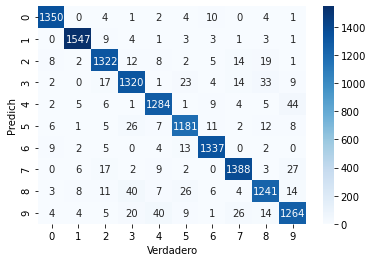

In [30]:
ax = plt.axes()

heatmap(confusion_rfc_prom, ax=ax, cmap="Blues", annot=True, fmt = "d")
plt.xlabel("Verdadero")
plt.ylabel("Predich")
plt.savefig("../scripts/imagenes/CONFUSION_RFC_promedio.png")

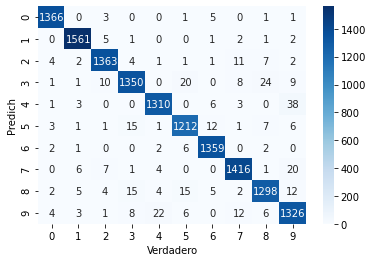

In [31]:
ax = plt.axes()
heatmap(confusion_knn_prom, ax=ax, cmap="Blues", annot=True, fmt = "d")
plt.xlabel("Verdadero")
plt.ylabel("Predich")
plt.savefig("../scripts/imagenes/CONFUSION_KNN_promedio.png")

In [39]:
precisionesPromedio = []
recallsPromedio = []
for k in range(10):
    precisionesPromedio.append(confusion_knn_prom[k][k]/(confusion_knn_prom[k].sum()))
    recallsPromedio.append(confusion_knn_prom[k][k]/(confusion_knn_prom[:,k].sum()))

recallsPromedio = pd.Series(recallsPromedio)
precisionesPromedio = pd.Series(precisionesPromedio)
precision_promedio = precisionesPromedio.mean()
recall_promedio = recallsPromedio.mean()

result = pd.DataFrame([precisionesPromedio,recallsPromedio]).T
result.columns = ["precision", "recall"]
index = result.index
index.name = "clase"
index = [str(i) for i in range(10)]
index.append("promedio")
result

,precision,recall
clase,,
0,0.992012,0.987708
1,0.992371,0.986102
2,0.976361,0.977762
3,0.948700,0.968436
4,0.962528,0.974702
5,0.962669,0.961142
6,0.990525,0.978402
7,0.973196,0.973196
8,0.953010,0.963623


In [40]:
promedios = pd.Series([result["precision"].mean(),result["recall"].mean()])
promedios.index = ["precision","recall"]
promedios.name = "promedio"
result = result.append(promedios)

In [41]:
result

,precision,recall
clase,,
0,0.992012,0.987708
1,0.992371,0.986102
2,0.976361,0.977762
3,0.948700,0.968436
4,0.962528,0.974702
5,0.962669,0.961142
6,0.990525,0.978402
7,0.973196,0.973196
8,0.953010,0.963623


In [42]:
import dataframe_image as dfi
dfi.export(result,"../scripts/imagenes/recalls-presiciones.jpg")
